In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
import pylab
from astropy.cosmology import FlatLambdaCDM
import astropy.coordinates as coord
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
import astropy.constants as const
import random

In [2]:
#Wu and Shen 2022
hdul = fits.open("dr16q_prop_Oct23_2022_core.fits")
# hdul.info()
data = hdul[1].data
header=hdul[1].header
hdul.close()

In [3]:
id = data['SDSS_NAME']
ra = data['RA']
dec = data['DEC']
z = data['Z_SYS']
z_err = data['Z_SYS_ERR']
lbol = data['LOGLBOL']
lbol_err = data['LOGLBOL_ERR']
mbh = data['LOGMBH_MGII']
mbh_err = data['LOGMBH_MGII_ERR']

In [4]:
#qs=(((qsample=='ugri') |(qsample=='boss_core') | (qsample=='eboss_core')) & (host_mass > MASSLIM) & (redshift > Z1) & (redshift < Z2) & (Li21b == 'True'))

# sample limits
Z1=1.7
Z2=1.75
DECLIMIT=15.0
RA_LOW=120
RA_HIGH=345
MASS1=8.2
MASS2=9.2
LBOL1=45.2
LBOL2=46.8

# conditions
index=((z > Z1) & (z < Z2) & 
       (ra > RA_LOW) & (ra < RA_HIGH) & 
       (dec < DECLIMIT) & 
       (mbh > MASS1) & (mbh < MASS2) & 
       (lbol > LBOL1) & (lbol < LBOL2))

index2 = ((z > Z1) & (z < Z2) & (dec < DECLIMIT))

red_sample = np.where(index)[0]

In [5]:
# for accelerating let's select only data from red sample
id_red = id[red_sample]
ra_red = ra[red_sample]
dec_red = dec[red_sample]
z_red = z[red_sample]
z_err_red = z_err[red_sample]
lbol_red = lbol[red_sample]
lbol_err_red = lbol_err[red_sample]
mbh_red = mbh[red_sample]
mbh_err_red = mbh_err[red_sample]

In [230]:
# let's create the bins for classification
dl=(LBOL2-LBOL1)/3
y_bin_edges = [LBOL2, LBOL2-dl, LBOL1+dl, LBOL1]

dm=(MASS2-MASS1)/3
x_bin_edges = [MASS1, MASS1+dm, MASS2-dm, MASS2]

bins_y = np.digitize(lbol_red, y_bin_edges, right=False)-1
bins_x = np.digitize(mbh_red, x_bin_edges, right=False)-1

# BINS map:
# 00, 01, 02, 
# 01, 11, 12,
# 02, 21, 22.


In [231]:
# create arrays with indices for each cell, for cell coordinates check bins map ^
bins_indices = {}
bins_indices_arr = [[],[],[]]
bit_counts = [[],[],[]]
for i in range(0,3): # X
    for j in range(0,3): # Y
        bins_indices[i,j] = np.where((bins_x == i) & (bins_y == j))[0]
        # bins_indices_arr[i].append((bins_indices[i,j]))
        bit_counts[i].append(len(bins_indices[i,j]))

        print(f"[{i}, {j}] bits_count: {len(bins_indices[i,j])}")

bit_counts = np.array(bit_counts)
#total number of objects per cell 
bit_counts

[0, 0] bits_count: 12
[0, 1] bits_count: 51
[0, 2] bits_count: 48
[1, 0] bits_count: 57
[1, 1] bits_count: 126
[1, 2] bits_count: 71
[2, 0] bits_count: 217
[2, 1] bits_count: 142
[2, 2] bits_count: 40


array([[ 12,  51,  48],
       [ 57, 126,  71],
       [217, 142,  40]])

In [234]:
def cluster_search(index, radius, ra, dec):
    """ This function will take index of on object, also coordinates 
        of the whole sample and will return indices of all objects 
        within a certain radius. 
    """

    center_idx = index
    center_coords = coord.SkyCoord(ra[center_idx]*u.degree, dec[center_idx]*u.degree)

    ra_coords = coord.Angle(ra*u.degree)
    dec_coords = coord.Angle(dec*u.degree)
    coords = coord.SkyCoord(ra_coords, dec_coords)

    all_points_separations = center_coords.separation(coords)
    selection = all_points_separations < radius * u.deg

    selection_indices = np.where(selection)[0]

    return selection_indices

In [511]:
#choose manually initial cell for sample selection (ideally it should be cell with the rearest objects)
init_cell = (0,0)
clusters_for_init_cell = {}
#choose also radius around objects from initial cell to select among more abundant objects. This will be the pointing radius.
r = 9.
for index in bins_indices[init_cell]:
    clusters_for_init_cell[index] = cluster_search(index, r, ra_red, dec_red)
#Now we have overdensitis for all objects from initial cell

In [512]:
# now choose number of pointings (n_pointings) you want to plan an also number of objects per cell (n_cell) to add to the final sample. 
# This number should be smaller or equal to the total number of objects in initial cell
n_pointings = 3
n_cell = 5

# Randomly select n_cell objects from initial cell
random_init_cell = random.sample(bins_indices[init_cell].tolist(), n_pointings)
random_init_cell

[485, 170, 148]

In [513]:
cells_count = np.array([[0,0,0],
                        [0,0,0],
                        [0,0,0]])

sample = [[[],[],[]],
          [[],[],[]],
          [[],[],[]]]

# Found all unique objects in all clusters
selection_indices = []

for index in random_init_cell:
    selection_indices += clusters_for_init_cell[index].tolist()

selection_indices_unique = np.unique(selection_indices)
for cell in bins_indices.keys():
    for idx in selection_indices_unique:
        if idx in bins_indices[cell]:
            cells_count[cell[0]][cell[1]] +=1
            sample[cell[0]][cell[1]].append(idx)

# Check how they are spreaded among cells
print(cells_count)

[[ 5 20 24]
 [13 46 41]
 [44 53 20]]


In [514]:
#convert coordinates of all objects for projection plot
ra_coords = coord.Angle(ra_red*u.degree)
dec_coords = coord.Angle(dec_red*u.degree)
coords = coord.SkyCoord(ra_coords, dec_coords)

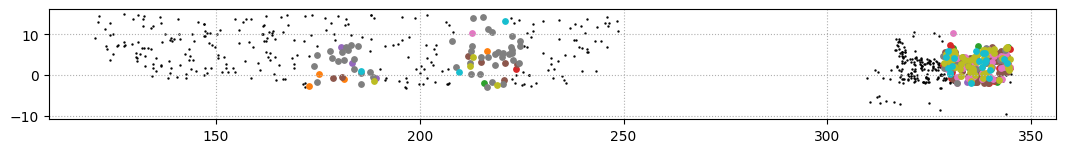

In [498]:
colors = [['C1', 'C2', 'C3'], 
          ['C4', 'C5', 'C6'], 
          ['C7', 'C8', 'C9']]

# plot all unique objects in all clusters
plt.figure(figsize=(13,10))
plt.subplot(111, aspect='equal')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.grid(linestyle=':')
plt.scatter(
    ra_red,
    dec_red,
    s=0.5,
    c='black'
)

for cell in bins_indices.keys():
    for idx in sample[cell[0]][cell[1]]:
        plt.scatter(
            coords[idx].icrs.ra.to('deg'),
            coords[idx].icrs.dec.to('deg'),
            s=15,
            marker='o',
            c=colors[cell[0]][cell[1]]
            )

plt.savefig(f"clusters_{r}deg.png",format='png',dpi=300)

In [509]:
# Randomly choose n_cell onjects from each cell to finilise sample.
final_sample = [[[],[],[]],[[],[],[]],[[],[],[]]]

for cell in bins_indices.keys():
    final_sample[cell[0]][cell[1]] = random.sample(sample[cell[0]][cell[1]], n_cell)


print(f"FINAL SAMPLE: {n_cell} per cell")
for col in final_sample:
    for row in col:
        print(row) 

FINAL SAMPLE: 5 per cell
[252, 637, 170, 148, 155]
[552, 551, 635, 727, 559]
[740, 629, 645, 739, 499]
[648, 194, 695, 730, 649]
[280, 643, 583, 265, 678]
[611, 654, 641, 690, 557]
[284, 183, 173, 632, 268]
[660, 756, 584, 743, 596]
[647, 530, 689, 734, 184]


[[5 5 5]
 [5 5 5]
 [5 5 5]]


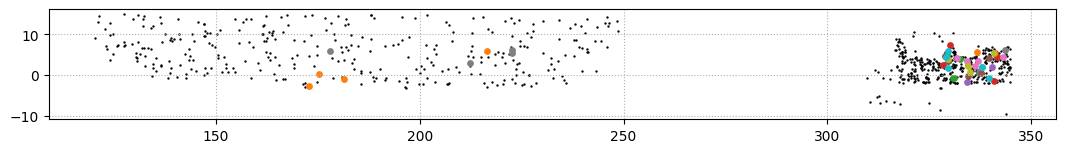

In [500]:
# plot all objects afom final sample
final_cells_count = np.array([[0,0,0],[0,0,0],[0,0,0]])

plt.figure(figsize=(13,10))
plt.subplot(111, aspect='equal')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
plt.grid(linestyle=':')
plt.scatter(
    ra_red,
    dec_red,
    s=0.5,
    c='black'
)


for cell in bins_indices.keys():
    for idx in final_sample[cell[0]][cell[1]]:
        final_cells_count[cell[0]][cell[1]] +=1
        plt.scatter(
            coords[idx].icrs.ra.to('deg'),
            coords[idx].icrs.dec.to('deg'),
            s=15,
            marker='o',
            c=colors[cell[0]][cell[1]]
            )

print(final_cells_count)

plt.savefig(f"final_clusters_{n_cell}per-cell_{r}deg.png",format='png',dpi=300)

In [501]:
# wrire the final sample id's and coordinates to the file
fout = open(f"{n_pointings}pointings_{n_cell}per-cell_{r}deg.txt", 'w')
fout.write(f"{'cell':6s}, {'ind':4s} {'id':20s} {'ra':15s} {'dec':15s}\n")
for cell in bins_indices:
    for ind in final_sample[cell[0]][cell[1]]:
        fout.write(f"{cell}, {ind:4d} {id_red[ind]:20s} {ra_red[ind]:15.11f} {dec_red[ind]:15.11f}\n")
fout.close()

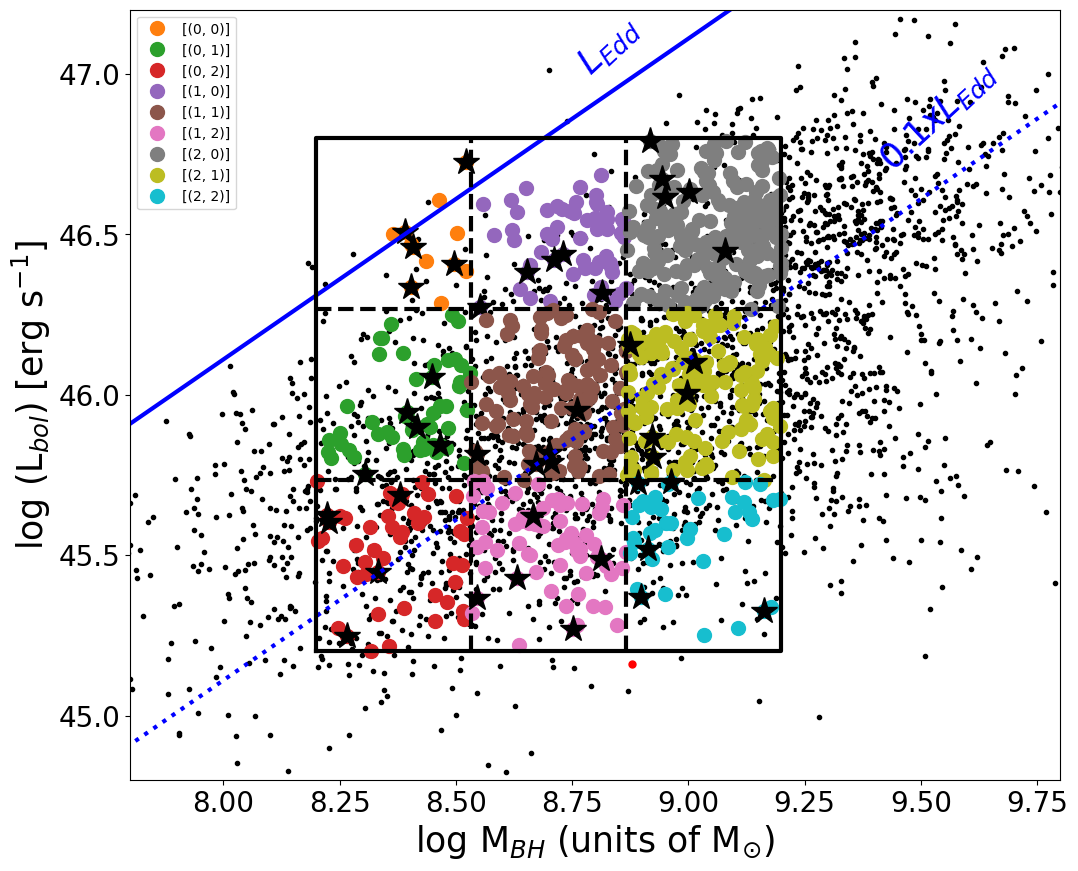

In [504]:
# plot final sample on the initial M(BH) vs L_bol plot.
fig = plt.figure(figsize=(12,10))
font_size = 20

ax=plt.gca()

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

ax.set_xlim([7.8,9.8])
ax.set_ylim([44.8,47.2])
ax.set_ylabel('log (L$_{bol}$) [erg s$^{-1}$]',fontsize=25)
ax.set_xlabel('log M$_{BH}$ (units of M$_{\odot}$)',fontsize=25)

ax.plot(mbh[index2],lbol[index2],'o',c='black',ms=3)
ax.plot(mbh[index],lbol[index],'o',c='red',ms=5)
# ax.plot(target_mass,target_lbol,'o',c='blue',ms=10)

for cell in bins_indices.keys():
    ax.plot(
        mbh_red[bins_indices[cell]], 
        lbol_red[bins_indices[cell]], 
        marker='o',
        linestyle='', 
        ms=10, 
        c=colors[cell[0]][cell[1]], 
        label=f"[{cell}]")
    
    ax.plot(
        mbh_red[final_sample[cell[0]][cell[1]]],
        lbol_red[final_sample[cell[0]][cell[1]]],
        marker='*',
        linestyle='',
        ms=20,
        c='black'
    )
    
ax.legend()

# ax.plot(mbh[red_sample][bins_indices[0,2]], lbol[red_sample][bins_indices[0,2]], 'o', c='green')

l=np.array([7,11])
m=np.array([45.11,49.11])
ax.plot(l,m,'blue',linewidth=3)
m=np.array([44.11,48.11])
ax.plot(l,m,'blue',linewidth=3,linestyle='dotted')
# black frame
black_frame_x = [MASS1, MASS1, MASS2, MASS2, MASS1]
black_frame_y = [LBOL1, LBOL2, LBOL2, LBOL1, LBOL1]
ax.plot(black_frame_x, black_frame_y, linewidth=3, color='black')

#divisions

dl=(LBOL2-LBOL1)/3
ax.plot([MASS1,MASS2],[LBOL1+dl,LBOL1+dl],'black',linewidth=3,linestyle='dashed')
ax.plot([MASS1,MASS2],[LBOL2-dl,LBOL2-dl],'black',linewidth=3,linestyle='dashed')

dm=(MASS2-MASS1)/3
ax.plot([MASS1+dm,MASS1+dm],[LBOL1,LBOL2],'black',linewidth=3,linestyle='dashed')
ax.plot([MASS2-dm,MASS2-dm],[LBOL1,LBOL2],'black',linewidth=3,linestyle='dashed')


ax.text(8.75,47.0,'$L_{Edd}$',color='blue',fontsize=25,rotation=43)
ax.text(9.4,46.7,'$0.1xL_{Edd}$',color='blue',fontsize=25,rotation=43)


plt.savefig(f"{n_cell}per-cell_sample.png",format='png',dpi=300)

In [10]:
id_parent = id[index]
ra_parent = ra[index]
dec_parent = dec[index]
z_parent=z[index]
lbol_parent=lbol[index]
mbh_parent=mbh[index]

with open('parent_sample.asc','w') as filehandle:
    for i in range(len(id_parent)):
        filehandle.write('{0} {1} {2} {3} {4} {5}\n'.format(id_parent[i],ra_parent[i],dec_parent[i],z_parent[i],lbol_parent[i],mbh_parent[i]))
filehandle.close()

In [11]:
#Target selection
cell_counts=np.zeros(9)
print(cell_counts)
a=0
b=0

for i in range(len(cell_counts)):
    
    lum=l1+a*dl
    mass=m1+b*dm
    subindex=((lbol_parent > lum) & (lbol_parent < lum+dl) & (mbh_parent < mass) & (mbh_parent < mass+dm)) 
    

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


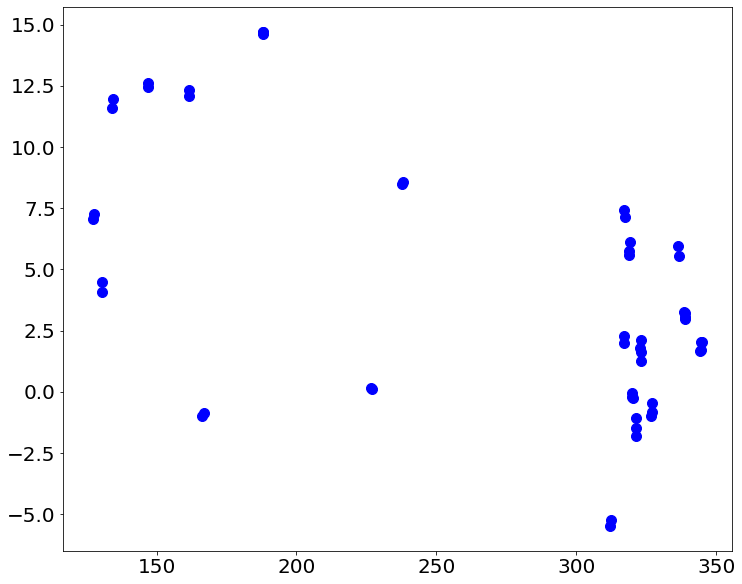

In [236]:
fig = plt.figure(figsize=(12,10))
font_size = 20

ax=plt.gca()

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


#ax.set_xlim([120,360])
ax.plot(target_ra,target_dec,'o',c='blue',ms=10)

In [231]:
print(np.shape(target_ra))

(49,)
